# Informe Accidentalidad - Barranquilla

### Descargamos e importamos instancias necesarias

In [6]:
%pip install sodapy
%pip install geopy
%pip install folium
%pip install googlemaps
import webbrowser
import pandas as pd
from sodapy import Socrata
import requests
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import googlemaps

# Configuración de no truncar visualización de los DF.
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Obtenemos los datos de: https://www.datos.gov.co/Transporte/Accidentalidad-en-Barranquilla/yb9r-2dsi/about_data

In [7]:
client = Socrata("www.datos.gov.co", None)
results_one = client.get("yb9r-2dsi", limit=50000)
results_df = pd.DataFrame.from_records(results_one)

results_two = client.get("cpp6-je64", limit=2000)
camaras_baq = pd.DataFrame.from_records(results_two)

results_three = client.get("xknx-agu2", limit=2000)
semaforizacion = pd.DataFrame.from_records(results_three)

In [8]:
results_df = results_df.map(lambda x: x.lower() if isinstance(x, str) else x)
meses_a_numeros = {
    'january': 1,
    'february': 2,
    'march': 3,
    'april': 4,
    'may': 5,
    'june': 6,
    'july': 7,
    'august': 8,
    'september': 9,
    'october': 10,
    'november': 11,
    'december': 12
}
results_df['mes_accidente'] = results_df['mes_accidente'].replace(meses_a_numeros).astype(str)
results_df['hora_accidente'] = pd.to_datetime(results_df['hora_accidente'], format='%I:%M:%S:%p')
results_df['fecha_accidente'] = pd.to_datetime(results_df['fecha_accidente'], format='mixed').dt.date
results_df['cant_heridos_en_sitio_accidente'] = results_df['cant_heridos_en_sitio_accidente'].fillna(0)


C:\Users\Andre\AppData\Local\Temp\ipykernel_8348\2949138528.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df['mes_accidente'] = results_df['mes_accidente'].replace(meses_a_numeros).astype(str)


### A partir de aquí, hacemos un analisis descriptivo de nuestros datos generales de accidentalidad en la ciudad de Barranquilla.

In [9]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26229 entries, 0 to 26228
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   fecha_accidente                  26229 non-null  object        
 1   hora_accidente                   26229 non-null  datetime64[ns]
 2   gravedad_accidente               26229 non-null  object        
 3   clase_accidente                  26229 non-null  object        
 4   sitio_exacto_accidente           26229 non-null  object        
 5   cant_heridos_en_sitio_accidente  26229 non-null  object        
 6   cantidad_accidentes              26229 non-null  object        
 7   a_o_accidente                    26229 non-null  object        
 8   mes_accidente                    26229 non-null  object        
 9   dia_accidente                    26229 non-null  object        
 10  cant_muertos_en_sitio_accidente  270 non-null    object   

#### Aquí podemos encontrar datos interesantes como por ejemplo:

1. El año en que se presentarón mas accidentes fue 2018, con un total de 5898.
2. El mes donde generalmente se presentan mas accidentes es febreo, con un total de 2347.
3. La ubicación de la ciudad con mas accidentes desde 2018 hasta agosto de 2023 fue CL 110 CR 9G.

In [10]:
description_df = results_df.describe(include='all')
description_df = description_df.loc[['count', 'unique', 'top', 'freq']]
description_df

,fecha_accidente,hora_accidente,gravedad_accidente,clase_accidente,sitio_exacto_accidente,cant_heridos_en_sitio_accidente,cantidad_accidentes,a_o_accidente,mes_accidente,dia_accidente,cant_muertos_en_sitio_accidente
count,26229,26229,26229,26229,26229,26229.0,26229,26229,26229,26229,270
unique,2508,NaN,3,6,15721,24.0,2,7,12,7,2
top,2018-06-08,NaN,solo daños,choque,cl 110 cr 9g,0.0,1.0,2018,2,tue,1.0
freq,34,NaN,15460,24338,77,15641.0,26224,5898,2477,4106,260


#### Apartir de aquí, tenemos graficas como parte de nuestro analisis descriptivo de ciertas variables importantes

##### Con este siguiente grafico podemos ver que el año en el que se presentaron mas accidentes fue en 2018. Además, podemos ver un bajo numero de accidentes en el año 2024 con respecto a los años anteriores. 

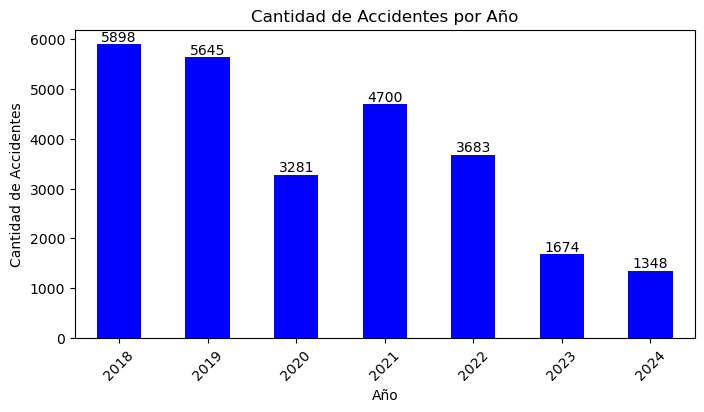

In [11]:
accidentes_por_año = results_df['a_o_accidente'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
bar_one = accidentes_por_año.plot.bar(x=accidentes_por_año.index, y=accidentes_por_año.values, color='blue')
plt.title('Cantidad de Accidentes por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(accidentes_por_año.values):
    bar_one.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

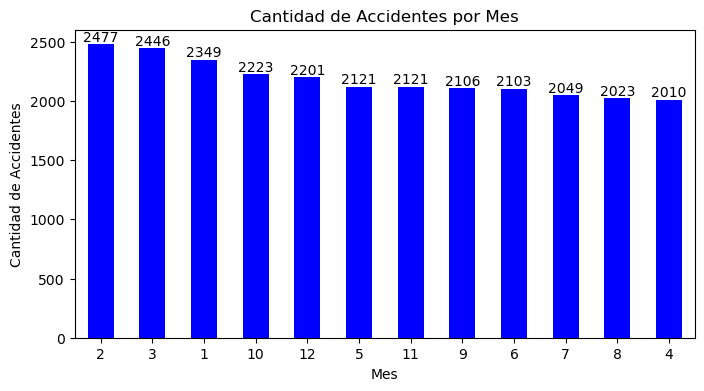

In [12]:
df_accidentes_por_mes = results_df['mes_accidente'].value_counts()
df_accidentes_por_mes.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 4))
bar_three = df_accidentes_por_mes.plot.bar(x=df_accidentes_por_mes.index, y=df_accidentes_por_mes.values, color='blue')
plt.title('Cantidad de Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=0)
for i, valor in enumerate(df_accidentes_por_mes.values):
    bar_three.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

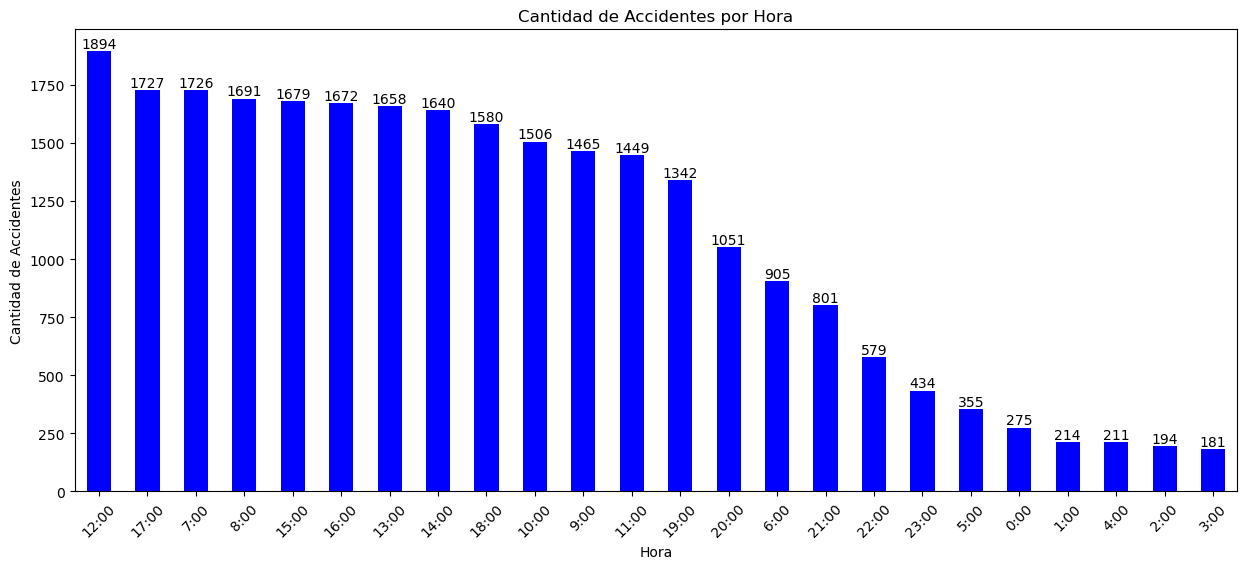

In [13]:
df_agrupado_por_hora = results_df.groupby(results_df['hora_accidente'].dt.hour).size()
df_agrupado_por_hora.index = df_agrupado_por_hora.index.astype(str) + ':00'
df_agrupado_por_hora.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(15, 6))
bar_three = df_agrupado_por_hora.plot.bar(x=df_agrupado_por_hora.index, y=df_agrupado_por_hora.values, color='blue')
plt.title('Cantidad de Accidentes por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(df_agrupado_por_hora.values):
    bar_three.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()


### Ahora, a partir de aquí, queremos hacer un analisis de estos datos de accidentalidad en este año 2024.

In [14]:
df_año = results_df[results_df["a_o_accidente"] == "2024"]
df_año = df_año.set_index(pd.RangeIndex(len(df_año.index)))

#### Ahora, para este nuevo dataset de accidentes en 2023, vamos a obtener información como sus colunmas y datos descriptivos de este.

In [15]:
df_año.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   fecha_accidente                  1348 non-null   object        
 1   hora_accidente                   1348 non-null   datetime64[ns]
 2   gravedad_accidente               1348 non-null   object        
 3   clase_accidente                  1348 non-null   object        
 4   sitio_exacto_accidente           1348 non-null   object        
 5   cant_heridos_en_sitio_accidente  1348 non-null   object        
 6   cantidad_accidentes              1348 non-null   object        
 7   a_o_accidente                    1348 non-null   object        
 8   mes_accidente                    1348 non-null   object        
 9   dia_accidente                    1348 non-null   object        
 10  cant_muertos_en_sitio_accidente  35 non-null     object     

In [16]:
description_df_año = df_año.describe(include='all')
description_df_año = description_df_año.loc[['count', 'unique', 'top', 'freq']]
description_df_año

,fecha_accidente,hora_accidente,gravedad_accidente,clase_accidente,sitio_exacto_accidente,cant_heridos_en_sitio_accidente,cantidad_accidentes,a_o_accidente,mes_accidente,dia_accidente,cant_muertos_en_sitio_accidente
count,1348,1348,1348,1348,1348,1348,1348,1348,1348,1348,35
unique,326,NaN,3,5,1236,12,1,1,11,7,2
top,2024-01-24,NaN,con heridos,choque,calle 110 carrera 43,1.0,1.0,2024,3,sat,1.0
freq,11,NaN,1308,1112,6,862,1348,1348,137,211,32


#### Continuando con la información acerca de nuestro conjunto de datos de 2024, hemos identificado el mes en el que se registró la mayor cantidad de accidentes. Observamos que febrero fue el mes con el mayor número, alcanzando un total de 158 accidentes.

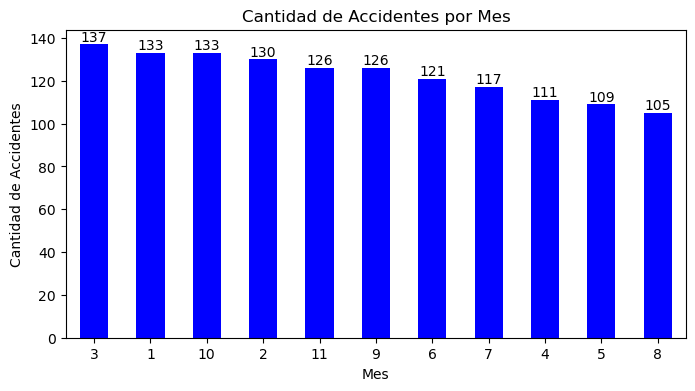

In [17]:
df_año_por_meses = df_año['mes_accidente'].value_counts()
df_año_por_meses.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 4))
bar_four = df_año_por_meses.plot.bar(x=df_año_por_meses.index, y=df_año_por_meses.values, color='blue')
plt.title('Cantidad de Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=0)
for i, valor in enumerate(df_año_por_meses.values):
    bar_four.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

#### Ahora bien, al tratar de encontrar una explicación del porqué febrero es el mes con más accidentes en Barranquilla, podemos tener en cuenta que durante este mes se celebra el Carnaval en la ciudad. Según los datos, este fin de semana festivo podría ser el periodo en el que se presentan más accidentes. En la siguiente celda, vamos a poner a prueba esta hipótesis.

In [18]:
fechas_mes_con_mas_accidentes_carnavales = results_df[(results_df['fecha_accidente'] >= pd.to_datetime('2024-02-17').date()) & (results_df['fecha_accidente'] <= pd.to_datetime('2024-02-21').date())]
fechas_mes_con_mas_accidentes_carnavales.shape[0]

print(f'La cantidad de accidentes en los días de carnaval fue de {fechas_mes_con_mas_accidentes_carnavales.shape[0]}.')
print(f'Esto representa el {round(fechas_mes_con_mas_accidentes_carnavales.shape[0] / df_año[df_año["mes_accidente"] == "2"].shape[0] * 100, 2)}% de los accidentes en el mes de febrero.')

La cantidad de accidentes en los días de carnaval fue de 25.
Esto representa el 19.23% de los accidentes en el mes de febrero.


#### Ahora bien, al analizar la cantidad de accidentes por hora, observamos un cambio en el año 2024 con respecto a los datos históricos. Desde 2018 hasta 2024, la hora con el mayor número de accidentes solía ser a las 12:00 PM, pero en 2024, la mayor cantidad se presenta a las 7:00 AM. Lo que queda claro es que durante las horas pico, experimentamos un aumento significativo en el número de accidentes en nuestra ciudad.

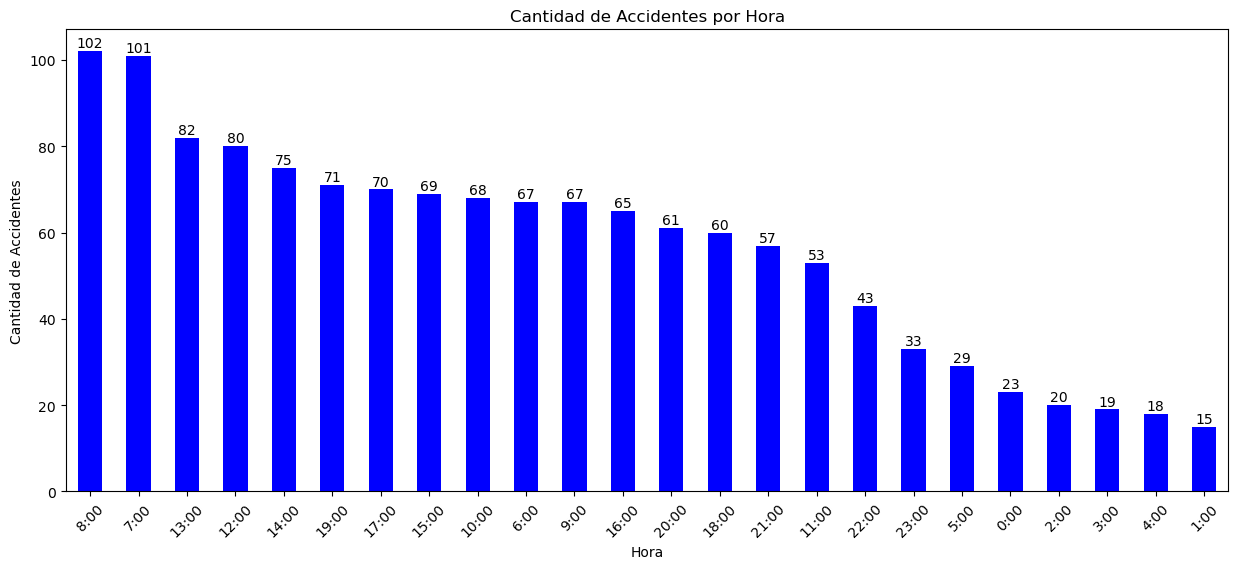

In [19]:
df_año_por_horas = df_año.groupby(df_año['hora_accidente'].dt.hour).size()
df_año_por_horas.index = df_año_por_horas.index.astype(str) + ':00'
df_año_por_horas.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(15, 6))
bar_five = df_año_por_horas.plot.bar(x=df_año_por_horas.index, y=df_año_por_horas.values, color='blue')
plt.title('Cantidad de Accidentes por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(df_año_por_horas.values):
    bar_five.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

### Finalmente, vamos a hacer un analisis graficos con geo-coordenadas de los accidentes presentados en este año 2024 y ver que regularidades e irregularedades podemos encontrar con respecto a temas como la semaforización o camaraás de transito.

#### En las siguientes celdas de código, tenemos funciones que nos ayudarán a encontrar las coordenadas de nuestro conjunto de datos de accidentes. En este conjunto de datos, no se especifican coordenadas; solo contamos con información de texto de las direcciones donde se presentaron los accidentes. Para ello, vamos a utilizar Azure Maps para obtener las coordenadas de una dirección registrada. También podríamos usar módulos de Python como Geopy; sin embargo, estos módulos presentan limitaciones en cuanto a direcciones, ya que algunas no pueden encontrarse con las coordenadas correctas.

In [20]:
# Función para obtener la latitud y longitud de una dirección con Geopy
def obtener_latitud_longitud_gmaps_api(direccion):
    gmaps = googlemaps.Client(key='API_KEY')
    resultado = gmaps.geocode(direccion)

    # Extrae la latitud y longitud si la respuesta es válida
    if resultado:
        latitud = resultado[0]['geometry']['location']['lat']
        longitud = resultado[0]['geometry']['location']['lng']
        return latitud, longitud
    else:
        return None, None

# Función para obtener la latitud y longitud de una dirección con Azure Maps
def obtener_latitud_longitud_azure(direccion):
    
    url = f"https://atlas.microsoft.com/search/address/json?api-version=1.0&subscription-key={'API_KEY'}&query={direccion}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            location = data['results'][0]['position']
            return location['lat'], location['lon']

    # Devuelve valores predeterminados si no se encuentra la ubicación
    return None, None

def obtener_latitud_longitud(direccion):
    latitud, longitud = obtener_latitud_longitud_gmaps_api(direccion)

    if latitud is None or longitud is None:
        latitud, longitud = obtener_latitud_longitud_azure(direccion)

    return latitud, longitud

In [21]:
latlong = []
# Iterar sobre las direcciones y obtener latitud y longitud
for direccion in df_año['sitio_exacto_accidente']:
    latitud, longitud = obtener_latitud_longitud_azure(f"{direccion}, Barranquilla, Atlántico")
    latlong.append({'Latitud': latitud, 'Longitud': longitud})

# Crear un DF con las latitudes y longitudes
latlong_df = pd.DataFrame(latlong)
# Guardar el DF en un archivo CSV
latlong_df.to_csv('coordenadas_accidentes_bquilla_año_gmaps_api.csv')

In [22]:
# Esta linea de código es para leer el archivo CSV con las coordenadas de los accidentes. 
# Si quieres seguir trabajando con el CSV ya creado es necesario que ejecutes esta linea y no la anterior, pero si quieres volver a crear el CSV con las coordenadas de los accidentes, entonces debes ejecutar las dos celdas ateriores.
df_accidentes_año_ubicacion = pd.concat([df_año, pd.read_csv('coordenadas_accidentes_bquilla_año_gmaps_api.csv')], axis=1)

In [23]:
df_accidentes_año_ubicacion.dropna(subset=['Latitud', 'Longitud'], inplace=True)
df_accidentes_año_ubicacion.to_csv('accidentes_bquilla_año_ubicacion_fulldataset.csv')
print(f"Dimensiones del DF: {df_accidentes_año_ubicacion.shape}")

Dimensiones del DF: (1348, 14)


#### En la siguiente celda de código, vamos a filtrar del conjunto de datos las coordenadas que no correspondan con las coordenadas geográficas de Barranquilla. Casi 100 de los 1500 accidentes reportados cuentan con direcciones que la API de Azure Maps no puede encontrar con precisión, y nos proporciona coordenadas erróneas. Por lo tanto, necesitamos realizar una limpieza previa de estos datos.

In [24]:
lat_min, lat_max = 10.8, 11.1
lon_min, lon_max = -75.0, -74.5

geoinfo_area_metropolitana_quilla = df_accidentes_año_ubicacion[
    (df_accidentes_año_ubicacion['Latitud'] >= lat_min) & (df_accidentes_año_ubicacion['Latitud'] <= lat_max) &
    (df_accidentes_año_ubicacion['Longitud'] >= lon_min) & (df_accidentes_año_ubicacion['Longitud'] <= lon_max)
]

print(f"Dimensiones del DF: {geoinfo_area_metropolitana_quilla.shape}")

Dimensiones del DF: (1195, 14)


### Luego, después de obtener nuestro Geo-Dataset y hacer una limpieza de este, es hora de comenzar a hacer gráficas con nuestros datos.

In [25]:
# Agregamos un mapa base con una localización inicial
barranquilla_map = folium.Map(location=[geoinfo_area_metropolitana_quilla['Latitud'].iloc[1], geoinfo_area_metropolitana_quilla['Longitud'].iloc[1]], zoom_start=13)

# Creamos una capa de puntos para los accidentes
accidentes = folium.FeatureGroup(name='Accidentes Puntuales', show=False).add_to(barranquilla_map)

# Agregamos los puntos al mapa
for index, row in geoinfo_area_metropolitana_quilla.iterrows():
    popup_text = f"Fecha: {row['fecha_accidente']}<br/> Hora: {row['hora_accidente']}<br/>Dirección: {row['sitio_exacto_accidente']}<br/>Clase Accidente: {row['clase_accidente']} <br/>Heridos: {row['cant_heridos_en_sitio_accidente']}"
    folium.Marker(location=[row['Latitud'], row['Longitud']], popup=popup_text).add_to(accidentes)


# Creamos una capa de clusters para los accidentes
marker_cluster = MarkerCluster(name='Accidentes Agrupados', show=True).add_to(barranquilla_map)

# Agregamos los puntos al mapa
for index, row in geoinfo_area_metropolitana_quilla.iterrows():
    popup_text = f"Fecha: {row['fecha_accidente']}<br/> Hora: {row['hora_accidente']}<br/>Dirección: {row['sitio_exacto_accidente']}<br/>Heridos: {row['cant_heridos_en_sitio_accidente']}"
    folium.Marker(location=[row['Latitud'], row['Longitud']], popup=popup_text).add_to(marker_cluster)


camaras = folium.FeatureGroup(name='Cámaras de Transito', show=False).add_to(barranquilla_map)

for index, row in camaras_baq.iterrows():
    popup_text = f"Nombre: {row['no']}<br/> Dirección: {row['name']}<br/> Tipo de Camara: {row['tipo_de_infracci_n']}<br/>"
    folium.Marker(location=[row['latitud'], row['longitud']], popup=popup_text, icon=folium.Icon(color='green')).add_to(camaras)

semaforos = folium.FeatureGroup(name='Semaforos', show=False).add_to(barranquilla_map)

for index, row in semaforizacion.iterrows():
    popup_text = f"Codigo: {row['codigo']}<br/> Estado: {row['estado']}<br/> Fecha de Funcionamiento: {row['fecha_inicio_de_funcionamiento']}<br/>"
    folium.Marker(location=[row['latitud'], row['longitud']], icon=folium.Icon(color='red')).add_to(semaforos)

# Agregamos una capa de control de capas al mapa
folium.LayerControl().add_to(barranquilla_map)

barranquilla_map.save("barranquilla_map.html")

# Abre el archivo HTML en el navegador predeterminado
webbrowser.open("barranquilla_map.html")


True